This script is an experiment in analyzing multi-hazard impacts on the power grid

The goal of this script is to identify a candidate set of wildfire + space weather events

It uses the following approach:
- Read in set of wildfire events from XXXX
- Get time period, get spatial extent (GIS) -> visualize it
- Highest level: get space weather indices
    - more granular is to get magnetometers and GNSS data (GIMs, likely) in the area of the fire 
- Get HIFLD grid affected based on the wildfire
- (optional) get observed power grid disturbances that overlap in space and time
- Record the candidate event for forensic analysis (social media, interviews, grey literature exploration)


(possibility of a new approach)
- Get wildfire point 
- Choose radius of some sort
- Get any power grid disturbance that occurred within that time and circle
- Inspect space weather data for preceding day to current time
- Store full multi-hazard data for the candidate event and study forensically


TODO
- the connection may very well come from space weather effects on communications during wildfire events (need to incorporate radiation data to represent space weather) 
- 

#### Dependencies and Custom Functions

In [1]:
import numpy as np
import pandas as pd
import os, sys

from datetime import datetime, time
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

from shapely.geometry import Polygon, MultiPolygon

import contextily as ctx


import supermag_api

import re


In [2]:
def get_sm_one_minute(start,end):

    '''

    
    Dependencies
        supermag-api downloadable from https://supermag.jhuapl.edu/mag/?fidelity=low&start=2001-01-01T00%3A00%3A00.000Z&interval=1%3A00%3A00&tab=api
            --> one should move this to the working directory and rename to supermag_api
        datetime
            
    Notes
        it appears this will only work for a few-day request; for longer periods, need to download the data directly
            
    '''


#     import supermag_api
#     import datetime

    start_datetime = pd.to_datetime(start)
    end_datetime = pd.to_datetime(end)
    
    # get the number of days between start and end
    num_days = (end_datetime - start_datetime).days
    print('the number of days that will be requested is {}'.format(num_days))
    input('Press Enter if you are sure you want to ping the SuperMAG API for this...')
    
    # get correct format for 'start date'
    date_obj_start = datetime.strptime(start, '%Y-%m-%d %H:%M:%S')
    formatted_start = date_obj_start.strftime('%Y-%m-%dT%H:%M')

    (status,df_smidxs) = supermag_api.SuperMAGGetIndices('rymc1012',formatted_start,86400*num_days,'SME, SMU, SML, SMR')

    datetimes_sm = [pd.to_datetime(t, unit='s') for t in df_smidxs['tval']]

    df_smidxs['datetimes'] = datetimes_sm
    df_smidxs = df_smidxs.set_index(['datetimes'])
    df_smidxs.index = pd.to_datetime(df_smidxs.index)
    
    return df_smidxs





#### Wildfire database

Some things I'm learning about wildfire data
- MODIS might be best available given coverage
- There is a NASA digital twin project https://ideas-digitaltwin.jpl.nasa.gov/airquality/, but it is focused on air quality and thus the atmospheric emissions associated with wildfire, whereas for this work I need the wildfires themselves (not their emissions which then mix with the atmosphere and its dynamics)
- ...


In [3]:
# NASA FIRMS data https://firms.modaps.eosdis.nasa.gov


# National Interagency Fire Center https://www.nifc.gov/
file_path_nifc_wildfire = "/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/wildfire_data/WFIGS_Incident_Locations_6818922478522849878.geojson"
file_path_modis_wildfire = "/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/wildfire_data/DL_FIRE_M-C61_530609/fire_archive_M-C61_530609.shp"
# file_path_suomi_wildfire = "/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/wildfire_data/DL_FIRE_SV-C2_530613/fire_archive_SV-C2_530613.shp"

# gdf_nifc_wildfire = gpd.read_file(file_path_nifc_wildfire)
gdf_modis_wildfire = gpd.read_file(file_path_modis_wildfire)
# gdf_suomi_wildfire = gpd.read_file(file_path_suomi_wildfire)




In [4]:
print('size of the wildfire data is: {:.2f} MB'.format(sys.getsizeof(gdf_modis_wildfire) / 10**6))

size of the wildfire data is: 42.44 MB


In [143]:
# Explore the first few rows
print(gdf_modis_wildfire.head())

# Check the geometry type (e.g., Point, Polygon, LineString)
print(gdf_modis_wildfire.geom_type.unique())

# Get summary of the attributes
print(gdf_modis_wildfire.info())

# # Plot the shapefile (quick visualization)
# gdf.plot()


   LATITUDE  LONGITUDE  BRIGHTNESS  SCAN  TRACK    ACQ_DATE ACQ_TIME  \
0   26.5690   -81.0586       328.5   2.5    1.5  2023-01-01     1819   
1   26.5640   -81.0828       327.4   2.5    1.5  2023-01-01     1819   
2   26.5611   -81.0496       318.6   2.5    1.5  2023-01-01     1819   
3   26.5507   -81.0793       310.5   2.5    1.5  2023-01-01     1819   
4   26.5557   -81.0552       310.1   2.5    1.5  2023-01-01     1819   

  SATELLITE INSTRUMENT  CONFIDENCE VERSION  BRIGHT_T31   FRP DAYNIGHT  TYPE  \
0      Aqua      MODIS          83   61.03       294.2  81.2        D     0   
1      Aqua      MODIS          82   61.03       294.4  76.7        D     0   
2      Aqua      MODIS          73   61.03       294.6  41.4        D     0   
3      Aqua      MODIS          57   61.03       293.5  17.9        D     0   
4      Aqua      MODIS          54   61.03       294.9  17.2        D     0   

                     geometry  
0  POINT (-81.05860 26.56900)  
1  POINT (-81.08280 26.56400

In [ ]:
# Explore the first few rows
print(gdf_suomi_wildfire.head())

# Check the geometry type (e.g., Point, Polygon, LineString)
print(gdf_suomi_wildfire.geom_type.unique())

# Get summary of the attributes
print(gdf_suomi_wildfire.info())

# # Plot the shapefile (quick visualization)
# gdf.plot()


In [144]:
if 'ACQ_DATE' in gdf_modis_wildfire.columns and 'ACQ_TIME' in gdf_modis_wildfire.columns:
    gdf_modis_wildfire['datetime'] = (
        gdf_modis_wildfire['ACQ_DATE'].astype(str) + ' ' + gdf_modis_wildfire['ACQ_TIME'].astype(str)
    )
    gdf_modis_wildfire['datetime'] = pd.to_datetime(gdf_modis_wildfire['datetime'])
else:
    raise ValueError("Expected 'ACQ_DATE' and 'ACQ_TIME' columns.")

In [ ]:
# # Group by unique acquisition dates and times
# unique_datetimes = gdf_modis_wildfire['datetime'].unique()

# # Loop over each unique datetime and plot the corresponding points
# for dt in unique_datetimes:
#     subset = gdf_modis_wildfire[gdf_modis_wildfire['datetime'] == dt]

#     # Plot the points for this specific acquisition time
#     fig, ax = plt.subplots(figsize=(10, 6))
#     subset.plot(ax=ax, color='red', marker='o', markersize=5)

#     # Customize plot title and labels
#     ax.set_title(f"Acquisition Date and Time: {dt}", fontsize=15)
#     ax.set_xlabel("Longitude")
#     ax.set_ylabel("Latitude")
    
# #     ax = subset.to_crs(epsg=3857).plot(ax=ax, color='red', marker='o', markersize=5)
#     ctx.add_basemap(ax)
    
#     # Display the plot
#     plt.show()
    
#     input('push any button...')

In [177]:
import folium
from folium.plugins import TimestampedGeoJson



In [ ]:
import folium
from folium.plugins import TimestampedGeoJson



# Convert GeoDataFrame to GeoJSON-like dictionary with timestamp for Folium
features = []
for _, row in gdf_modis_wildfire.iterrows():
    feature = {
        'type': 'Feature',
        'geometry': row['geometry'].__geo_interface__,
        'properties': {
            'time': row['datetime'].isoformat(),  # Use ISO format for timestamps
            'popup': f"Acquired: {row['datetime']}"
        }
    }
    features.append(feature)

# Create the Timestamped GeoJSON layer
timestamped_geojson = TimestampedGeoJson(
    {'type': 'FeatureCollection', 'features': features},
    period='PT1H',  # Period for animation: 1 hour
    add_last_point=False,
    auto_play=False,
    loop=True,
    max_speed=1,
    loop_button=True,
    date_options='YYYY-MM-DD HH:mm:ss',
    time_slider_drag_update=True
)

# Initialize a Folium map centered on the dataset's centroid
m = folium.Map(
    location=[gdf_modis_wildfire.geometry.y.mean(), gdf_modis_wildfire.geometry.x.mean()],
    zoom_start=6, tiles='CartoDB positron'
)

# Add the timestamped layer to the map
timestamped_geojson.add_to(m)

# Save the map as an HTML file and display it
m.save('interactive_map.html')

# If running in Jupyter, display the map directly
m


In [173]:
# Create a list of features grouped by unique timestamps
features = []
for dt, group in gdf_modis_wildfire.groupby('datetime'):
    feature = {
        'type': 'FeatureCollection',
        'features': [
            {
                'type': 'Feature',
                'geometry': row['geometry'].__geo_interface__,
                'properties': {
                    'time': dt.isoformat(),  # Set timestamp in ISO format
                    'popup': f"Acquired: {dt}"
                }
            }
            for _, row in group.iterrows()
        ]
    }
    features.append(feature)


# # Create the TimestampedGeoJson with these features
# timestamped_geojson = TimestampedGeoJson(
#     {'type': 'FeatureCollection', 'features': features},
#     period='PT1H',              # Set period of time for each step (1 hour)
#     add_last_point=False,        # Ensure only current points appear
#     auto_play=False,              # Automatically start animation
#     loop=True,                   # Loop the animation
#     max_speed=1,                 # Normal animation speed
#     loop_button=True,            # Allow user to loop animation
#     date_options='YYYY-MM-DD HH:mm:ss',  # Display format for timestamps
#     time_slider_drag_update=True # Update on dragging time slider
# )

# # Initialize the Folium map centered on the dataset's centroid
# m = folium.Map(
#     location=[gdf_modis_wildfire.geometry.y.mean(), gdf_modis_wildfire.geometry.x.mean()],
#     zoom_start=6, 
#     tiles='CartoDB positron'  # Light basemap
# )

# # Add the timestamped GeoJSON to the map
# timestamped_geojson.add_to(m)

# # Save the map as an HTML file and display it
# m.save('interactive_map.html')

# # If running in Jupyter, display the map directly
# m

#### HIFLD data
uses HIFLD data: https://hifld-geoplatform.hub.arcgis.com/datasets/geoplatform::transmission-lines

In [145]:
file_path_powergrid = "/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/physical_grid_data/U.S._Electric_Power_Transmission_Lines.geojson"
gdf_powergrid = gpd.read_file(file_path_powergrid)



In [146]:
print('size of the power grid data is: {:.2f} MB'.format(sys.getsizeof(gdf_powergrid) / 10**6))

size of the power grid data is: 94.45 MB


#### Power Grid Disturbance Data

Candidates
- [new dataset from EAGLE-I](https://www.nature.com/articles/s41597-024-03095-5) (Data are available in the Figshare repository at https://doi.org/10.6084/m9.figshare.24237376) 
- [DOE electric disturbance events OE-417](https://www.oe.netl.doe.gov/OE417_annual_summary.aspx)


New Candidate: [NASA Black Marble](https://blackmarble.gsfc.nasa.gov/) (will require more thinking about how we might use these data)


In [147]:
# Read in 2023 data
outage_directory = '/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/outage_data/'
oe417 = pd.read_excel(os.path.join(outage_directory,'DOE-OE-417/2023_Annual_Summary.xlsx'),header=1)
oe417 = oe417.dropna(subset=['Time Event Began'])
oe417 = oe417.iloc[:-2]
for o in range(len(oe417['Number of Customers Affected'])):
    if oe417['Number of Customers Affected'].iloc[o]=='Unknown':
        oe417['Number of Customers Affected'].iloc[o] = np.nan
    elif type(oe417['Number of Customers Affected'].iloc[o]) == str: 
        oe417['Number of Customers Affected'].iloc[o] = int(oe417['Number of Customers Affected'].iloc[o])
    
oe417 = oe417[oe417['Number of Customers Affected']>1000]

eaglei = pd.read_csv(os.path.join(outage_directory,'EAGLE-I/eaglei_outages_2023.csv'))
eaglei = eaglei[eaglei['customers_out']>1000]


In [148]:
print('size of the oe417 data is: {:.2f} MB'.format(sys.getsizeof(oe417) / 10**6))
print('size of the eaglei data is: {:.2f} MB'.format(sys.getsizeof(eaglei) / 10**6))

size of the oe417 data is: 0.07 MB
size of the eaglei data is: 6.67 MB


In [9]:
oe417

Event Month     Date Event Began Time Event Began  Date of Restoration  \
2       January           01/01/2023         14:47:00           01/01/2023   
5       January           01/02/2023         18:22:00           01/02/2023   
7       January           01/05/2023         08:19:00           01/05/2023   
10      January           01/07/2023         22:00:00           01/08/2023   
11      January           01/07/2023         23:44:00           01/08/2023   
..          ...                  ...              ...                  ...   
336    December  2023-12-18 00:00:00         05:45:00            - Unknown   
338    December  2023-12-19 00:00:00         00:41:00  2023-12-19 00:00:00   
340    December  2023-12-23 00:00:00         00:43:00  2023-12-23 00:00:00   
342    December  2023-12-25 00:00:00         19:56:00  2023-12-25 00:00:00   
344    December  2023-12-27 00:00:00         14:44:00  2023-12-28 00:00:00   

    Time of Restoration                                      Area Affected  \
2              16:50:00                            Florida: Citrus County;   
5              22:27:00  Arkansas: Union County; Louisiana: Ouachita Pa...   
7              08:20:00                       Louisiana: Concordia Parish;   
10             21:00:00                     California: Sacramento County;   
11             02:29:00                Texas: Jasper County, Tyler County;   
..                  ...                                                ...   
336           - Unknown                                    ISO New England   
338            00:47:00                                        LUMA Energy   
340            00:48:00                                        LUMA Energy   
342            20:01:00                                        LUMA Energy   
344            04:14:00                                Otter Tail Power Co   

    NERC Region                                     Alert Criteria  \
2          SERC  Physical attack that could potentially impact ...   
5          SERC  Unexpected Transmission loss within its area, ...   
7          SERC  Electrical System Separation (Islanding) where...   
10         WECC  Loss of electric service to more than 50,000 c...   
11          TRE  Unexpected Transmission loss within its area, ...   
..          ...                                                ...   
336        WECC  Loss of electric service to more than 50,000 c...   
338         NaN  Firm load shedding of 100 Megawatts or more im...   
340         NaN  Firm load shedding of 100 Megawatts or more im...   
342         NaN  Firm load shedding of 100 Megawatts or more im...   
344         MRO  Electrical System Separation (Islanding) where...   

                        Event Type Demand Loss (MW)  \
2                        Vandalism               19   
5                   Severe Weather               20   
7        Transmission Interruption               23   
10                  Severe Weather              458   
11       Transmission Interruption               20   
..                             ...              ...   
336  - Weather or natural disaster          Unknown   
338    - Generator loss or failure               77   
340    - Generator loss or failure               65   
342    - Generator loss or failure              105   
344  - Weather or natural disaster               14   

    Number of Customers Affected  
2                           3509  
5                           6849  
7                           1631  
10                        185434  
11                          9823  
..                           ...  
336                       730000  
338                        50204  
340                        37850  
342                        36100  
344                         8000  

[85 rows x 11 columns]

In [149]:

from dateutil.parser import parse

def get_datetime_oe417(date,time):
    # try: 
    #     dt = datetime.combine(str_date,dt_time)
    # except: 
    #     try:
    #         date_obj = datetime.strptime(str_date, '%m/%d/%Y')
    #         # dt = datetime.combine(date_obj, dt_time)
    #         dt = parse(date_obj+' '+dt_time)
    #     except:
    #         dt = np.nan

    if type(date) == str:
        date_obj = datetime.strptime(date, '%m/%d/%Y')
        dt = datetime.combine(date_obj,time)
    else:
        dt = datetime.combine(date,time)
    
    return dt

# Regular expression to capture 'State: County' pairs
pattern = r'(\w+):\s*([\w\s-]+)'

# Function to extract states and counties from each row
# def extract_state_county_pairs(row):
#     pairs = []
#     # Split by semicolon to handle multiple state-county pairs
#     entries = row.split(';')
#     for entry in entries:
#         # Use regex to extract state and county
#         match = re.match(r'(\w+):\s*(.*)', entry.strip())
#         if match:
#             state = match.group(1)
#             county = match.group(2)
#             pairs.append((state, county))
#     return pairs

def extract_state_county_pairs(location_str):
    pairs = []

    # Split by ';' to handle multiple state-county blocks
    state_county_blocks = location_str.split(';')

    for block in state_county_blocks:
        block = block.strip()

        # Case: Handle multiple consecutive states without counties (e.g., "Alabama: Maine:")
        if re.fullmatch(r"(.+?:)+", block):
            states = [state.strip() for state in block.split(':') if state.strip()]
            for state in states:
                pairs.append((state, None))  # Store each state with None for county
            continue  # Skip further processing for this block

        # Use regex to match "State: County, County, ..." or "State:"
        match = re.match(r"(.+?):\s*(.*)", block)

        if match:
            state = match.group(1).strip()
            counties = match.group(2).strip()

            if counties:  # If counties exist, split them by ','
                counties_list = [county.strip() for county in counties.split(',')]
                for county in counties_list:
                    pairs.append((state, county))
            else:  # If no counties are provided
                pairs.append((state, None))
        else:
            # If the block contains only a state name
            pairs.append((block, None))

    return pairs


def get_oe417_geometries(row_area_affected,gdf_states,gdf_counties):
    '''
        inputs: 
            - row of oe417 data for Area Affected (oe417['Area Affected'].iloc[x])
            - data for states geometries
            - data for county geometries
        dependencies:
            - extract_state_county_pairs function
    '''
    
    row_states_counties = extract_state_county_pairs(row_area_affected)
    all_geometries = []
    for l in row_states_counties: 
        if not l[0]:
            # skip the empty rows in the extracted data
            continue
        else:
            if not l[1]:
                # if there is no county data, then just use whole state
                geom_data_tmp = gpd.GeoSeries(gdf_states['geometry'][gdf_states['NAME'] == l[0]].values)
                if geom_data_tmp.empty:
                    continue
                if geom_data_tmp.apply(lambda geom: isinstance(geom, MultiPolygon)).all():
#                     print('----> encountering multipolygon for {}, skipping'.format(l[0]))
                    all_geometries.extend([polygon for polygon in geom_data_tmp.geometry[0].geoms])
                else:
                    all_geometries.extend( [Polygon(geom_data_tmp.geometry[0])] )
            else:
                # if there is county data, get the county geometries and combine them
                fips_tmp = get_fips(l[0])
                geom_data_tmp = gpd.GeoSeries(gdf_counties['geometry'][ (gdf_counties['STATEFP'] == fips_tmp) & (gdf_counties['NAMELSAD'] == l[1]) ].values)
                if geom_data_tmp.empty:
                    continue
                if geom_data_tmp.apply(lambda geom: isinstance(geom, MultiPolygon)).all():
#                     print('----> encountering multipolygon for {}, skipping'.format(l[0]))
                    all_geometries.extend([polygon for polygon in geom_data_tmp.geometry[0].geoms])
                else:
                    all_geometries.extend( [Polygon(geom_data_tmp.geometry[0])] )

    combined_geometry = gpd.GeoSeries(all_geometries).unary_union

    return combined_geometry, row_states_counties

def get_eaglei_geometries(row_county,row_state,gdf_states,gdf_counties):
    '''
        inputs: 
            - row of eaglei data for county (eagelei['county'].iloc[x])
            - row of eaglei data for state (eagelei['state'].iloc[x])
            - data for states geometries
            - data for county geometries
        dependencies:
            - extract_state_county_pairs function
    '''
    
    all_geometries = []
    fips_tmp = get_fips(row_state)
    geom_data_tmp = gpd.GeoSeries(gdf_counties['geometry'][ (gdf_counties['STATEFP'] == fips_tmp) & (gdf_counties['NAMELSAD'] == row_county + ' County') ].values)
    if geom_data_tmp.empty:
        return np.nan
    if geom_data_tmp.apply(lambda geom: isinstance(geom, MultiPolygon)).all():
        all_geometries.extend([polygon for polygon in geom_data_tmp.geometry[0].geoms])
    else:
        all_geometries.extend( [Polygon(geom_data_tmp.geometry[0])] )
    

    combined_geometry = gpd.GeoSeries(all_geometries).unary_union

    return combined_geometry

# Dictionary mapping state abbreviations to FIPS codes
# List of tuples containing (state_abbreviation, fips_code, full_state_name)
state_fips = [
    ('AL', '01', 'Alabama'),
    ('AK', '02', 'Alaska'),
    ('AZ', '04', 'Arizona'),
    ('AR', '05', 'Arkansas'),
    ('CA', '06', 'California'),
    ('CO', '08', 'Colorado'),
    ('CT', '09', 'Connecticut'),
    ('DE', '10', 'Delaware'),
    ('FL', '12', 'Florida'),
    ('GA', '13', 'Georgia'),
    ('HI', '15', 'Hawaii'),
    ('ID', '16', 'Idaho'),
    ('IL', '17', 'Illinois'),
    ('IN', '18', 'Indiana'),
    ('IA', '19', 'Iowa'),
    ('KS', '20', 'Kansas'),
    ('KY', '21', 'Kentucky'),
    ('LA', '22', 'Louisiana'),
    ('ME', '23', 'Maine'),
    ('MD', '24', 'Maryland'),
    ('MA', '25', 'Massachusetts'),
    ('MI', '26', 'Michigan'),
    ('MN', '27', 'Minnesota'),
    ('MS', '28', 'Mississippi'),
    ('MO', '29', 'Missouri'),
    ('MT', '30', 'Montana'),
    ('NE', '31', 'Nebraska'),
    ('NV', '32', 'Nevada'),
    ('NH', '33', 'New Hampshire'),
    ('NJ', '34', 'New Jersey'),
    ('NM', '35', 'New Mexico'),
    ('NY', '36', 'New York'),
    ('NC', '37', 'North Carolina'),
    ('ND', '38', 'North Dakota'),
    ('OH', '39', 'Ohio'),
    ('OK', '40', 'Oklahoma'),
    ('OR', '41', 'Oregon'),
    ('PA', '42', 'Pennsylvania'),
    ('RI', '44', 'Rhode Island'),
    ('SC', '45', 'South Carolina'),
    ('SD', '46', 'South Dakota'),
    ('TN', '47', 'Tennessee'),
    ('TX', '48', 'Texas'),
    ('UT', '49', 'Utah'),
    ('VT', '50', 'Vermont'),
    ('VA', '51', 'Virginia'),
    ('WA', '53', 'Washington'),
    ('WV', '54', 'West Virginia'),
    ('WI', '55', 'Wisconsin'),
    ('WY', '56', 'Wyoming'),
]

def get_fips(state_name):
    for abbr, fips, name in state_fips:
        if name.upper() == state_name.upper():
            return fips
    return None, None  # Return None if not found

##### Country/State location data
Geting the data from [US Census Bureau Tiger platform](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html)

In [150]:
gdf_states = gpd.read_file('/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/location_data/Census_Bureau_Data/tl_2023_us_state/tl_2023_us_state.shp')
gdf_counties = gpd.read_file('/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/location_data/Census_Bureau_Data/tl_2023_us_county/tl_2023_us_county.shp')

In [151]:
print('size of the states data is: {:.2f} MB'.format(sys.getsizeof(gdf_states) / 10**6))
print('size of the counties data is: {:.2f} MB'.format(sys.getsizeof(gdf_counties) / 10**6))


size of the states data is: 0.05 MB
size of the counties data is: 3.16 MB


In [152]:
# Merge into one outage data file as a gpd
outage_columns = ['outage_start_time', 'outage_stop_time', 'customers_affected','geometry','source']
outage_data_gdf = gpd.GeoDataFrame(pd.DataFrame(columns=outage_columns), geometry='geometry')

outage_data_gdf.set_crs("EPSG:4326", inplace=True)  # WGS84 - lat/lon

Empty GeoDataFrame
Columns: [outage_start_time, outage_stop_time, customers_affected, geometry, source]
Index: []

In [153]:
# growing the outage data with oe417 data

for o in range(len(oe417)):
    
    # get start and end times
    str_date_start = oe417['Date Event Began'].iloc[o]
    dt_time_start = oe417['Time Event Began'].iloc[o]
    str_date_end = oe417['Date of Restoration'].iloc[o]
    dt_time_end = oe417['Time of Restoration'].iloc[o]
    try:
        dt_start = get_datetime_oe417(str_date_start,dt_time_start)
    except:
        dt_start = np.nan
    try:
        dt_end = get_datetime_oe417(str_date_end,dt_time_end)
    except:
        dt_end = np.nan    

    # get the geometries of the areas affected
    combined_geometry, states_counties = get_oe417_geometries(oe417['Area Affected'].iloc[o],gdf_states,gdf_counties)
    
    
    outage_data_gdf = outage_data_gdf.append({
                                            'source': 'oe417', 
                                            'area affected': states_counties, 
                                            'outage_start_time': dt_start,
                                            'outage_stop_time': dt_end,
                                            'customers_affected': oe417['Number of Customers Affected'].iloc[o],
                                            'geometry': combined_geometry
                                                }, ignore_index=True)

    

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_20334/1358008190.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_20334/1358008190.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_20334/1358008190.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_20334/1358008190.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

In [156]:

outage_data_gdf#['outage_start_time'].isna().sum()

outage_start_time    outage_stop_time customers_affected  \
0  2023-01-01 14:47:00 2023-01-01 16:50:00               3509   
1  2023-01-02 18:22:00 2023-01-02 22:27:00               6849   
2  2023-01-05 08:19:00 2023-01-05 08:20:00               1631   
3  2023-01-07 22:00:00 2023-01-08 21:00:00             185434   
4  2023-01-07 23:44:00 2023-01-08 02:29:00               9823   
..                 ...                 ...                ...   
80 2023-12-18 05:45:00                 NaT             730000   
81 2023-12-19 00:41:00 2023-12-19 00:47:00              50204   
82 2023-12-23 00:43:00 2023-12-23 00:48:00              37850   
83 2023-12-25 19:56:00 2023-12-25 20:01:00              36100   
84 2023-12-27 14:44:00 2023-12-28 04:14:00               8000   

                                             geometry source  \
0   POLYGON ((-83.18791 28.98657, -82.99976 28.989...  oe417   
1   MULTIPOLYGON (((-91.93628 32.65886, -91.93574 ...  oe417   
2   POLYGON ((-91.51807 31.52815, -91.51818 31.527...  oe417   
3   POLYGON ((-121.43991 38.25553, -121.44002 38.2...  oe417   
4   POLYGON ((-94.45780 31.03333, -94.45746 31.033...  oe417   
..                                                ...    ...   
80                                               None  oe417   
81                                               None  oe417   
82                                               None  oe417   
83                                               None  oe417   
84                                               None  oe417   

                                        area affected  
0                [(Florida, Citrus County), (, None)]  
1   [(Arkansas, Union County), (Louisiana, Ouachit...  
2           [(Louisiana, Concordia Parish), (, None)]  
3         [(California, Sacramento County), (, None)]  
4   [(Texas, Jasper County), (Texas, Tyler County)...  
..                                                ...  
80                          [(ISO New England, None)]  
81                              [(LUMA Energy, None)]  
82                              [(LUMA Energy, None)]  
83                              [(LUMA Energy, None)]  
84                      [(Otter Tail Power Co, None)]  

[85 rows x 6 columns]

In [ ]:
# growing the outage data with eaglei data

for e in range(len(eaglei)):
    
    # get start times
    try:
        dt_start = pd.to_datetime(eaglei['run_start_time'].iloc[e], format='%m/%d/%y %H:%M')
    except:
        dt_start = np.nan
    
    combined_geometry = get_eaglei_geometries(eaglei['county'].iloc[e],eaglei['state'].iloc[e],gdf_states,gdf_counties)
    
    outage_data_gdf = outage_data_gdf.append({
                                                'source': 'eaglei', 
                                                'area affected': [(eaglei['state'].iloc[e],eaglei['county'].iloc[e]+' County')], 
                                                'outage_start_time': dt_start,
                                                'outage_stop_time': np.nan,
                                                'customers_affected': eaglei['customers_out'].iloc[e],
                                                'geometry': combined_geometry
                                                    }, ignore_index=True)

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  outage_data_gdf = outage_data_gdf.append({
/var/folders/56/vhtxcmr565z5ksdt3g3px27w0000gq/T/ipykernel_55220/1970426275.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
 

PICK UP HERE WITH....

    - check the issue with datetimes in the 2023 eaglei data (how to get the actual times of outages, not 'collection run time'
    - need to aggregate close wildfire points into single 'event'

In [157]:
gdf_modis_wildfire

LATITUDE  LONGITUDE  BRIGHTNESS  SCAN  TRACK    ACQ_DATE ACQ_TIME  \
0       26.5690   -81.0586       328.5   2.5    1.5  2023-01-01     1819   
1       26.5640   -81.0828       327.4   2.5    1.5  2023-01-01     1819   
2       26.5611   -81.0496       318.6   2.5    1.5  2023-01-01     1819   
3       26.5507   -81.0793       310.5   2.5    1.5  2023-01-01     1819   
4       26.5557   -81.0552       310.1   2.5    1.5  2023-01-01     1819   
...         ...        ...         ...   ...    ...         ...      ...   
93995   35.5124   -81.4234       306.1   1.2    1.1  2023-12-31     1913   
93996   35.5149   -81.4294       304.1   1.2    1.1  2023-12-31     1913   
93997   36.5638   -85.6422       311.3   1.0    1.0  2023-12-31     1913   
93998   30.7894  -100.6265       305.4   2.2    1.4  2023-12-31     2050   
93999   30.7888  -100.6316       305.9   2.2    1.4  2023-12-31     2050   

      SATELLITE INSTRUMENT  CONFIDENCE VERSION  BRIGHT_T31   FRP DAYNIGHT  \
0          Aqua      MODIS          83   61.03       294.2  81.2        D   
1          Aqua      MODIS          82   61.03       294.4  76.7        D   
2          Aqua      MODIS          73   61.03       294.6  41.4        D   
3          Aqua      MODIS          57   61.03       293.5  17.9        D   
4          Aqua      MODIS          54   61.03       294.9  17.2        D   
...         ...        ...         ...     ...         ...   ...      ...   
93995      Aqua      MODIS          63   61.03       284.9  10.4        D   
93996      Aqua      MODIS          58   61.03       285.0   9.5        D   
93997      Aqua      MODIS          71   61.03       283.7  12.6        D   
93998      Aqua      MODIS          56   61.03       294.7  13.1        D   
93999      Aqua      MODIS          58   61.03       294.6  14.5        D   

       TYPE                     geometry            datetime  
0         0   POINT (-81.05860 26.56900) 2023-01-01 18:19:00  
1         0   POINT (-81.08280 26.56400) 2023-01-01 18:19:00  
2         0   POINT (-81.04960 26.56110) 2023-01-01 18:19:00  
3         0   POINT (-81.07930 26.55070) 2023-01-01 18:19:00  
4         0   POINT (-81.05520 26.55570) 2023-01-01 18:19:00  
...     ...                          ...                 ...  
93995     0   POINT (-81.42340 35.51240) 2023-12-31 19:13:00  
93996     0   POINT (-81.42940 35.51490) 2023-12-31 19:13:00  
93997     0   POINT (-85.64220 36.56380) 2023-12-31 19:13:00  
93998     0  POINT (-100.62650 30.78940) 2023-12-31 20:50:00  
93999     0  POINT (-100.63160 30.78880) 2023-12-31 20:50:00  

[94000 rows x 17 columns]

#### Candidate search


In [ ]:
# first group the modis wildfire data by datetime and nearby lat-long points
import geopandas as gpd
from shapely.geometry import Point, MultiPoint

def aggregate_points_within_radius(gdf, radius=0.01):
    """
    Aggregates points by datetime and spatial proximity into polygons.

    Parameters:
    - df: GeoDataFrame with columns ["datetime", "geometry"]
    - radius: Proximity radius in degrees (~0.01 degrees ≈ 1.1 km) for grouping
    
    Returns:
    - A new GeoDataFrame with datetime and polygon geometry
    """
    # Group by datetime
    grouped = gdf.groupby('datetime')

    result_rows = []

    for datetime_value, group in grouped:
        points = group['geometry'].tolist()
        clustered_points = []

        # Track visited points
        visited = set()

        for i, point in enumerate(points):
            if i in visited:
                continue

            # Start a cluster
            cluster = [point]
            visited.add(i)

            for j, other_point in enumerate(points):
                if j not in visited and point.distance(other_point) <= radius:
                    cluster.append(other_point)
                    visited.add(j)

            # Create a polygon from the clustered points
            polygon = MultiPoint(cluster).convex_hull
            result_rows.append({
                'datetime': datetime_value,
                'geometry': polygon
            })

    # Create a new GeoDataFrame from the result
    result_gdf = gpd.GeoDataFrame(result_rows, columns=['datetime', 'geometry'], crs=gdf.crs)
    return result_gdf


# Example usage with your GeoDataFrame
output_gdf = aggregate_points_within_radius(your_gdf, radius=0.01)
print(output_gdf)



In [159]:
grouped_modis_tmp = gdf_modis_wildfire.groupby('datetime')


In [168]:
print('size of the grouped data is: {:.2f} MB'.format(sys.getsizeof(grouped_modis_tmp) / 10**6))


size of the grouped data is: 0.00 MB


In [196]:



# for dt_tmp_value, group in grouped_modis_tmp:
#     print(dt_tmp_value)
#     points = group['geometry'].tolist()
#     print(points)

#     # plot
#     # Initialize the Folium map centered on the dataset's centroid
#     m = folium.Map(
#         location=[39.5, -98.4],
#         zoom_start=6, 
#         tiles='CartoDB positron'  # Light basemap
#     )

#     points_tmp = points_tmp.rename(columns={0:'geometry'})

    
#     # Add points from the GeoDataFrame to the map
#     for point in points_tmp.geometry:
#         folium.Marker(
#             location=[point.y, point.x],
#             popup=f"Point: ({point.y}, {point.x})"
#         ).add_to(m)
    
#     m    
    
    
#     input('pausing until entering...')
    
first_group_name, first_group_data = next(iter(grouped_modis_tmp))
print(first_group_data)
points = first_group_data['geometry'].tolist()
print(points)

# plot
# Initialize the Folium map centered on the dataset's centroid
m = folium.Map(
    location=[39.5, -98.4],
    zoom_start=6, 
    tiles='CartoDB positron'  # Light basemap
)

points_tmp = points_tmp.rename(columns={0:'geometry'})


# Add points from the GeoDataFrame to the map
for point in points_tmp.geometry:
    folium.Marker(
        location=[point.y, point.x],
        popup=f"Point: ({point.y}, {point.x})"
    ).add_to(m)

m    

   LATITUDE  LONGITUDE  BRIGHTNESS  SCAN  TRACK    ACQ_DATE ACQ_TIME  \
0   26.5690   -81.0586       328.5   2.5    1.5  2023-01-01     1819   
1   26.5640   -81.0828       327.4   2.5    1.5  2023-01-01     1819   
2   26.5611   -81.0496       318.6   2.5    1.5  2023-01-01     1819   
3   26.5507   -81.0793       310.5   2.5    1.5  2023-01-01     1819   
4   26.5557   -81.0552       310.1   2.5    1.5  2023-01-01     1819   
5   26.5563   -81.0738       341.6   2.5    1.5  2023-01-01     1819   

  SATELLITE INSTRUMENT  CONFIDENCE VERSION  BRIGHT_T31    FRP DAYNIGHT  TYPE  \
0      Aqua      MODIS          83   61.03       294.2   81.2        D     0   
1      Aqua      MODIS          82   61.03       294.4   76.7        D     0   
2      Aqua      MODIS          73   61.03       294.6   41.4        D     0   
3      Aqua      MODIS          57   61.03       293.5   17.9        D     0   
4      Aqua      MODIS          54   61.03       294.9   17.2        D     0   
5      Aqua    

In [191]:
points_tmp#.columns.tolist()

geometry
0   POINT (-81.0586 26.569)
1   POINT (-81.0828 26.564)
2  POINT (-81.0496 26.5611)
3  POINT (-81.0793 26.5507)
4  POINT (-81.0552 26.5557)
5  POINT (-81.0738 26.5563)

In [199]:
from shapely.geometry import Point, MultiPoint

In [225]:
grouped = gdf_modis_wildfire.groupby('datetime')

result_rows = []

for datetime_value, group in grouped:
    points = group['geometry'].tolist()
    clustered_points = []

    # Track visited points
    visited = set()

    for i, point in enumerate(points):
        if i in visited:
            continue

        # Start a cluster
        cluster = [point]
        visited.add(i)

        for j, other_point in enumerate(points):
            if j not in visited:# and point.distance(other_point) <= .1:
                cluster.append(other_point)
                visited.add(j)

        # Create a polygon from the clustered points
        polygon = MultiPoint(cluster).convex_hull
        result_rows.append({
            'datetime': datetime_value,
            'geometry': polygon
        })

# Create a new GeoDataFrame from the result
gdf_modis_wildfire_result = gpd.GeoDataFrame(result_rows, columns=['datetime', 'geometry'], crs=gdf_modis_wildfire.crs)


In [ ]:
import geopandas as gpd
import folium
import time
from shapely.geometry import Point, Polygon
from IPython.display import display, clear_output


# Create a Folium map centered over CONUS
conus_map = folium.Map(location=[37.5, -95], zoom_start=5)

for index, row in gdf_modis_wildfire_result.iterrows():
    geom = row.geometry

    # Check if the geometry is a Point
    if geom.geom_type == 'Point':
        marker_layer = folium.Marker(
            location=[geom.y, geom.x],
            popup="Point Geometry"
        ).add_to(conus_map)
    
    # Check if the geometry is a Polygon
    elif geom.geom_type == 'Polygon':
        poly_layer = folium.Polygon(
            locations=[(y, x) for x, y in geom.exterior.coords],
            color="blue",
            fill=True,
            fill_opacity=0.4,
            popup="Polygon Geometry"
        ).add_to(conus_map)

    # Display the map
    clear_output(wait=True)
    display(conus_map)

    # Remove the layer for the next iteration
    if geom.geom_type == 'Point':
        conus_map._children.pop(marker_layer.get_name())
    elif geom.geom_type == 'Polygon':
        conus_map._children.pop(poly_layer.get_name())

    # Pause for visualization
    time.sleep(10)


In [236]:
outage_data_gdf

outage_start_time    outage_stop_time customers_affected  \
0  2023-01-01 14:47:00 2023-01-01 16:50:00               3509   
1  2023-01-02 18:22:00 2023-01-02 22:27:00               6849   
2  2023-01-05 08:19:00 2023-01-05 08:20:00               1631   
3  2023-01-07 22:00:00 2023-01-08 21:00:00             185434   
4  2023-01-07 23:44:00 2023-01-08 02:29:00               9823   
..                 ...                 ...                ...   
80 2023-12-18 05:45:00                 NaT             730000   
81 2023-12-19 00:41:00 2023-12-19 00:47:00              50204   
82 2023-12-23 00:43:00 2023-12-23 00:48:00              37850   
83 2023-12-25 19:56:00 2023-12-25 20:01:00              36100   
84 2023-12-27 14:44:00 2023-12-28 04:14:00               8000   

                                             geometry source  \
0   POLYGON ((-83.18791 28.98657, -82.99976 28.989...  oe417   
1   MULTIPOLYGON (((-91.93628 32.65886, -91.93574 ...  oe417   
2   POLYGON ((-91.51807 31.52815, -91.51818 31.527...  oe417   
3   POLYGON ((-121.43991 38.25553, -121.44002 38.2...  oe417   
4   POLYGON ((-94.45780 31.03333, -94.45746 31.033...  oe417   
..                                                ...    ...   
80                                               None  oe417   
81                                               None  oe417   
82                                               None  oe417   
83                                               None  oe417   
84                                               None  oe417   

                                        area affected  
0                [(Florida, Citrus County), (, None)]  
1   [(Arkansas, Union County), (Louisiana, Ouachit...  
2           [(Louisiana, Concordia Parish), (, None)]  
3         [(California, Sacramento County), (, None)]  
4   [(Texas, Jasper County), (Texas, Tyler County)...  
..                                                ...  
80                          [(ISO New England, None)]  
81                              [(LUMA Energy, None)]  
82                              [(LUMA Energy, None)]  
83                              [(LUMA Energy, None)]  
84                      [(Otter Tail Power Co, None)]  

[85 rows x 6 columns]

In [247]:

radius = 0.1  # Example radius in degrees (adjust based on your CRS)

candidates = []
# candidate_columns = ['outage_start_time', 'outage_stop_time', 'customers_affected','geometry','source']
# candidate_gdf = gpd.GeoDataFrame(pd.DataFrame(columns=outage_columns), geometry='geometry')


# for w in range(len(gdf_modis_wildfire)):
for index_w, row_w in gdf_modis_wildfire_result.iterrows():
    
    # Identify overlap in time with the power grid disturbance
    wildfire_datetime = row_w.datetime #gdf_modis_wildfire['datetime'].iloc[w]
    filtered_outage_data_gdf = outage_data_gdf[
                                            (outage_data_gdf['outage_start_time'] >= wildfire_datetime - pd.Timedelta(hours=1)) &
                                            (outage_data_gdf['outage_start_time'] <= wildfire_datetime + pd.Timedelta(days=1))
                                            ]
    
    # Identify overlap in space with the power grid disturbance
    geom = row_w.geometry
    
    # Check if the geometry is a Point
    if geom.geom_type == 'Point':
        #   Create a buffer (circular area) around the point
        wildfire_point = gdf_modis_wildfire['geometry'].iloc[w]
        buffered_wildfire_area = geom.buffer(radius)
        disp_geom = geom.coords[0]

    # Check if the geometry is a Polygon
    elif geom.geom_type == 'Polygon':
        buffered_wildfire_area = geom
        disp_geom = geom.exterior.coords[0]

    
    for f in range(len(filtered_outage_data_gdf)):
        if buffered_wildfire_area.intersects(filtered_outage_data_gdf['geometry'].iloc[f]):
            
            # Check space weather data for space weather conditions (if at any time in the surrounding 24 hours AE exceeded 200 nT)
            sm_data = get_sm_one_minute((wildfire_datetime - pd.Timedelta(hours=24)).strftime('%Y-%-m-%-d %H:%M:%S'),
                                        (wildfire_datetime + pd.Timedelta(hours=12)).strftime('%Y-%-m-%-d %H:%M:%S'))
            
            if sm_data['SME'][sm_data['SME']>200.].any():


                # save as a candidate
                print('candidate at {}! \n wildfire: \n \t {} \n outage: \n \t {} for {} \n sp wx: \n \t {} at {}'.format(wildfire_datetime,
                                                                                                                             disp_geom,
                                                                                                                             filtered_outage_data_gdf['outage_start_time'].iloc[f],
                                                                                                                             filtered_outage_data_gdf['area affected'].iloc[f],
                                                                                                                             sm_data['SME'][sm_data['SME']==sm_data['SME'].max()].values,
                                                                                                                             sm_data.index[sm_data['SME']==sm_data['SME'].max()].values,))
                candidates.append({
                                    'wildfire datetime': wildfire_datetime,
                                    'wildfire geometry': geom,
                                    'outage_start_time': filtered_outage_data_gdf['outage_start_time'].iloc[f],
                                    'outage_stop_time': filtered_outage_data_gdf['outage_stop_time'].iloc[f],
                                    'customers affected': filtered_outage_data_gdf['customers_affected'].iloc[f],
                                    'outage geometry': filtered_outage_data_gdf['geometry'].iloc[f],
                                    'area affected': filtered_outage_data_gdf['area affected'].iloc[f],
                                    'max SME': sm_data['SME'][sm_data['SME']==sm_data['SME'].max()].values,

                                    })
                break
    continue
                
            
can

the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-01-07 04:10:00! 
 wildfire: 
 	 (-97.5908, 27.8072) 
 outage: 
 	 2023-01-07 23:44:00 for [('Texas', 'Jasper County'), ('Texas', 'Tyler County'), ('', None)] 
 sp wx: 
 	 [234.766418] at ['2023-01-07T00:05:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-01-11 15:41:00! 
 wildfire: 
 	 (-82.4514, 32.6894) 
 outage: 
 	 2023-01-12 14:00:00 for [('Alabama', None), ('Georgia', None)] 
 sp wx: 
 	 [503.498718] at ['2023-01-10T22:48:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-01-11 15:42:00! 
 wildfire: 
 	 (-82.2786, 29.3265) 
 outage: 
 	 2023-01-12 14:00:00 for [('Alabama', None), ('Georgia', None)] 
 sp wx: 
 	 [503.498718] at ['2023-01-10T22:48:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-01-11 18:53:00! 
 wildfire: 
 	 (-82.2929, 29.3187) 
 outage: 
 	 2023-01-12 14:00:00 for [('Alabama', None), ('Georgia', None)] 
 sp wx: 
 	 [503.498718] at ['2023-01-10T22:48:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-01-11 18:54:00! 
 wildfire: 
 	 (-82.7434, 32.9896) 
 outage: 
 	 2023-01-12 14:00:00 for [('Alabama', None), ('Georgia', None)] 
 sp wx: 
 	 [503.498718] at ['2023-01-10T22:48:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-01-23 17:23:00! 
 wildfire: 
 	 (-96.8342, 28.6828) 
 outage: 
 	 2023-01-24 15:25:00 for [('Texas', 'Harris County'), ('', None)] 
 sp wx: 
 	 [767.988037] at ['2023-01-23T14:08:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-01-23 19:12:00! 
 wildfire: 
 	 (-90.837, 29.6284) 
 outage: 
 	 2023-01-24 15:25:00 for [('Texas', 'Harris County'), ('', None)] 
 sp wx: 
 	 [767.988037] at ['2023-01-23T14:08:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-01-24 19:55:00! 
 wildfire: 
 	 (-99.9677, 30.6221) 
 outage: 
 	 2023-01-25 03:30:00 for [('Arkansas', None), ('Texas', None), ('Louisiana', None), ('Mississippi', None)] 
 sp wx: 
 	 [444.479645] at ['2023-01-23T22:32:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-02-20 19:21:00! 
 wildfire: 
 	 (-97.9498, 27.3197) 
 outage: 
 	 2023-02-21 13:14:00 for [('Florida', 'Orange County'), ('', None)] 
 sp wx: 
 	 [521.609131] at ['2023-02-20T18:13:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-03-22 20:54:00! 
 wildfire: 
 	 (-114.9734, 35.869) 
 outage: 
 	 2023-03-23 00:39:00 for [('Nevada', 'Clark County'), ('', None)] 
 sp wx: 
 	 [1162.580811] at ['2023-03-22T09:28:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-03-30 19:58:00! 
 wildfire: 
 	 (-92.7692, 34.4832) 
 outage: 
 	 2023-03-31 18:00:00 for [('Arkansas', None)] 
 sp wx: 
 	 [1141.916382] at ['2023-03-30T19:47:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-03-31 19:03:00! 
 wildfire: 
 	 (-97.5189, 35.5637) 
 outage: 
 	 2023-03-31 20:49:00 for [('Illinois', None)] 
 sp wx: 
 	 [1141.916382] at ['2023-03-30T19:47:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-04-15 17:48:00! 
 wildfire: 
 	 (-100.7977, 32.8079) 
 outage: 
 	 2023-04-16 07:17:00 for [('Texas', None), ('Louisiana', None), ('Arkansas', None), ('Mississippi', None)] 
 sp wx: 
 	 [811.331543] at ['2023-04-15T12:55:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-04-15 19:44:00! 
 wildfire: 
 	 (-98.0957, 27.2058) 
 outage: 
 	 2023-04-16 07:17:00 for [('Texas', None), ('Louisiana', None), ('Arkansas', None), ('Mississippi', None)] 
 sp wx: 
 	 [811.331543] at ['2023-04-15T12:55:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-04-15 19:45:00! 
 wildfire: 
 	 (-94.8123, 32.2359) 
 outage: 
 	 2023-04-16 07:17:00 for [('Texas', None), ('Louisiana', None), ('Arkansas', None), ('Mississippi', None)] 
 sp wx: 
 	 [811.331543] at ['2023-04-15T12:55:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-04-15 19:46:00! 
 wildfire: 
 	 (-95.3235, 35.0513) 
 outage: 
 	 2023-04-16 07:17:00 for [('Texas', None), ('Louisiana', None), ('Arkansas', None), ('Mississippi', None)] 
 sp wx: 
 	 [811.331543] at ['2023-04-15T12:55:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-04-28 16:53:00! 
 wildfire: 
 	 (-98.0256, 26.127) 
 outage: 
 	 2023-04-29 00:00:00 for [('Texas', 'Hidalgo County'), ('Texas', 'Cameron County'), ('Texas', 'Willacy County'), ('Texas', 'Starr County'), ('', None)] 
 sp wx: 
 	 [1058.05835] at ['2023-04-28T04:17:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-06-21 19:14:00! 
 wildfire: 
 	 (-93.3361, 31.0453) 
 outage: 
 	 2023-06-22 02:30:00 for [('Louisiana', None)] 
 sp wx: 
 	 [566.164673] at ['2023-06-21T04:50:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-06-23 19:04:00! 
 wildfire: 
 	 (-88.2926, 46.5819) 
 outage: 
 	 2023-06-24 18:17:00 for [('Michigan', None)] 
 sp wx: 
 	 [876.719055] at ['2023-06-23T17:43:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-06-24 16:22:00! 
 wildfire: 
 	 (-84.4855, 42.7173) 
 outage: 
 	 2023-06-24 18:17:00 for [('Michigan', None)] 
 sp wx: 
 	 [918.188354] at ['2023-06-24T05:49:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-06-24 16:23:00! 
 wildfire: 
 	 (-87.4079, 39.3433) 
 outage: 
 	 2023-06-24 18:17:00 for [('Michigan', None)] 
 sp wx: 
 	 [918.188354] at ['2023-06-24T05:49:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-06-24 16:24:00! 
 wildfire: 
 	 (-85.4864, 34.8794) 
 outage: 
 	 2023-06-25 06:45:00 for [('Tennessee', None)] 
 sp wx: 
 	 [918.188354] at ['2023-06-24T05:49:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-06-24 16:25:00! 
 wildfire: 
 	 (-88.2356, 31.5966) 
 outage: 
 	 2023-06-25 06:45:00 for [('Tennessee', None)] 
 sp wx: 
 	 [918.188354] at ['2023-06-24T05:49:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-06-25 07:45:00! 
 wildfire: 
 	 (-83.43, 31.1678) 
 outage: 
 	 2023-06-25 06:45:00 for [('Tennessee', None)] 
 sp wx: 
 	 [1481.621216] at ['2023-06-25T01:12:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-06-28 15:50:00! 
 wildfire: 
 	 (-76.463, 40.1176) 
 outage: 
 	 2023-06-29 15:42:00 for [('Indiana', None)] 
 sp wx: 
 	 [632.900085] at ['2023-06-28T03:48:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-07-19 19:10:00! 
 wildfire: 
 	 (-94.4801, 29.6233) 
 outage: 
 	 2023-07-20 16:30:00 for [('Georgia', None)] 
 sp wx: 
 	 [305.050293] at ['2023-07-19T12:38:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-07-20 16:07:00! 
 wildfire: 
 	 (-82.3547, 29.4952) 
 outage: 
 	 2023-07-20 16:30:00 for [('Georgia', None)] 
 sp wx: 
 	 [275.894287] at ['2023-07-20T15:22:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-07-25 16:12:00! 
 wildfire: 
 	 (-83.7897, 39.4317) 
 outage: 
 	 2023-07-26 14:51:00 for [('Michigan', 'Oakland County'), ('Michigan', 'Wayne County'), ('Michigan', 'Macomb County'), ('Michigan', 'Washtenaw County'), ('Michigan', 'Livingston County'), ('', None)] 
 sp wx: 
 	 [856.831055] at ['2023-07-25T16:11:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-07-27 18:14:00! 
 wildfire: 
 	 (-79.17, 36.6974) 
 outage: 
 	 2023-07-28 18:00:00 for [('West Virginia', None), ('Virginia', None)] 
 sp wx: 
 	 [508.741852] at ['2023-07-26T19:37:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-07-28 16:36:00! 
 wildfire: 
 	 (-88.4287, 41.3937) 
 outage: 
 	 2023-07-28 22:58:00 for [('Wisconsin', 'Jefferson County'), ('Wisconsin', 'Waukesha County'), ('Wisconsin', 'Milwaukee County'), ('Wisconsin', 'Sheboygan County'), ('Wisconsin', 'Washington County'), ('Wisconsin', 'Ozaukee County'), ('Wisconsin', 'Walworth County'), ('Wisconsin', 'Kenosha County'), ('Wisconsin', 'Racine County'), ('Michigan', None)] 
 sp wx: 
 	 [443.383423] at ['2023-07-28T14:57:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-07-28 18:56:00! 
 wildfire: 
 	 (-94.3861, 34.3002) 
 outage: 
 	 2023-07-28 18:00:00 for [('West Virginia', None), ('Virginia', None)] 
 sp wx: 
 	 [443.383423] at ['2023-07-28T14:57:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-07-28 18:57:00! 
 wildfire: 
 	 (-94.3861, 34.3002) 
 outage: 
 	 2023-07-28 18:00:00 for [('West Virginia', None), ('Virginia', None)] 
 sp wx: 
 	 [443.383423] at ['2023-07-28T14:57:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-09-24 20:04:00! 
 wildfire: 
 	 (-100.446, 30.8778) 
 outage: 
 	 2023-09-24 23:44:00 for [('Texas', 'Dallas County'), ('Texas', 'Tarrant County'), ('Texas', 'McLennan County'), ('Texas', 'Angelina County'), ('Texas', 'Bell County'), ('Texas', 'Williamson County'), ('Texas', 'Smith County'), ('', None)] 
 sp wx: 
 	 [637.28833] at ['2023-09-24T08:51:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-09-24 20:05:00! 
 wildfire: 
 	 (-100.446, 30.8778) 
 outage: 
 	 2023-09-24 23:44:00 for [('Texas', 'Dallas County'), ('Texas', 'Tarrant County'), ('Texas', 'McLennan County'), ('Texas', 'Angelina County'), ('Texas', 'Bell County'), ('Texas', 'Williamson County'), ('Texas', 'Smith County'), ('', None)] 
 sp wx: 
 	 [637.28833] at ['2023-09-24T08:51:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-09-25 03:50:00! 
 wildfire: 
 	 (-93.9262, 29.7266) 
 outage: 
 	 2023-09-25 05:12:00 for [('Louisiana', 'East Baton Rouge Parish'), ('', None)] 
 sp wx: 
 	 [1573.613037] at ['2023-09-24T20:46:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-09-25 03:51:00! 
 wildfire: 
 	 (-93.9262, 29.7266) 
 outage: 
 	 2023-09-25 05:12:00 for [('Louisiana', 'East Baton Rouge Parish'), ('', None)] 
 sp wx: 
 	 [1573.613037] at ['2023-09-24T20:46:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-09-29 18:35:00! 
 wildfire: 
 	 (-120.5171, 37.0352) 
 outage: 
 	 2023-09-29 22:16:00 for [('California', 'Butte County'), ('', None)] 
 sp wx: 
 	 [902.839355] at ['2023-09-29T10:52:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-10-04 17:05:00! 
 wildfire: 
 	 (-95.2874, 32.9278) 
 outage: 
 	 2023-10-04 22:01:00 for [('Texas', None)] 
 sp wx: 
 	 [705.591797] at ['2023-10-03T17:58:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-10-04 17:06:00! 
 wildfire: 
 	 (-95.2874, 32.9278) 
 outage: 
 	 2023-10-04 22:01:00 for [('Texas', None)] 
 sp wx: 
 	 [705.591797] at ['2023-10-03T17:58:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-10-04 17:07:00! 
 wildfire: 
 	 (-99.4458, 27.8067) 
 outage: 
 	 2023-10-04 22:01:00 for [('Texas', None)] 
 sp wx: 
 	 [705.591797] at ['2023-10-03T17:58:00.000000000']
the number of days that will be requested is 1


Press Enter if you are sure you want to ping the SuperMAG API for this... 


candidate at 2023-10-04 20:28:00! 
 wildfire: 
 	 (-99.244, 28.9953) 
 outage: 
 	 2023-10-04 22:01:00 for [('Texas', None)] 
 sp wx: 
 	 [521.514771] at ['2023-10-04T00:07:00.000000000']


In [249]:
candidates

[{'wildfire datetime': Timestamp('2023-01-07 04:10:00'),
  'wildfire geometry': <POLYGON ((-97.591 27.807, -96.693 30.551, -93.317 30.194, -92.922 29.805, -...>,
  'outage_start_time': Timestamp('2023-01-07 23:44:00'),
  'outage_stop_time': Timestamp('2023-01-08 02:29:00'),
  'customers affected': 9823,
  'outage geometry': <POLYGON ((-94.458 31.033, -94.457 31.033, -94.45 31.035, -94.448 31.036, -9...>,
  'area affected': [('Texas', 'Jasper County'),
   ('Texas', 'Tyler County'),
   ('', None)],
  'max SME': array([234.766418])},
 {'wildfire datetime': Timestamp('2023-01-11 15:41:00'),
  'wildfire geometry': <POLYGON ((-82.451 32.689, -82.468 32.978, -82.078 33.11, -79.532 33.726, -8...>,
  'outage_start_time': Timestamp('2023-01-12 14:00:00'),
  'outage_stop_time': Timestamp('2023-01-13 03:00:00'),
  'customers affected': 162000,
  'outage geometry': <POLYGON ((-85.003 31.001, -85.003 31.001, -85.003 31.001, -85.003 31.001, -...>,
  'area affected': [('Alabama', None), ('Georgia', No

In [251]:
gdf_candidates

wildfire datetime                                  wildfire geometry  \
0  2023-01-07 04:10:00  POLYGON ((-97.5908 27.8072, -96.6931 30.5511, ...   
1  2023-01-11 15:41:00  POLYGON ((-82.4514 32.6894, -82.4681 32.9785, ...   
2  2023-01-11 15:42:00  POLYGON ((-82.2786 29.3265, -82.2924 29.328, -...   
3  2023-01-11 18:53:00  POLYGON ((-82.2929 29.3187, -91.0701 30.0902, ...   
4  2023-01-11 18:54:00  POLYGON ((-82.7434 32.9896, -95.0548 33.8018, ...   
5  2023-01-23 17:23:00  POLYGON ((-96.8342 28.6828, -104.7759 30.8824,...   
6  2023-01-23 19:12:00  POLYGON ((-90.837 29.6284, -92.4218 29.6549, -...   
7  2023-01-24 19:55:00                           POINT (-99.9677 30.6221)   
8  2023-02-20 19:21:00  POLYGON ((-97.9498 27.3197, -98.3125 27.551, -...   
9  2023-03-22 20:54:00  POLYGON ((-114.9734 35.869, -114.9641 35.8799,...   
10 2023-03-30 19:58:00  POLYGON ((-92.7692 34.4832, -92.7761 34.4912, ...   
11 2023-03-31 19:03:00  POLYGON ((-97.5189 35.5637, -97.5215 35.5773, ...   
12 2023-04-15 17:48:00  POLYGON ((-100.7977 32.8079, -108.5254 37.3928...   
13 2023-04-15 19:44:00  POLYGON ((-98.0957 27.2058, -96.7593 29.2218, ...   
14 2023-04-15 19:45:00  POLYGON ((-94.8123 32.2359, -96.5941 32.2881, ...   
15 2023-04-15 19:46:00  POLYGON ((-95.3235 35.0513, -92.9702 36.9964, ...   
16 2023-04-28 16:53:00  POLYGON ((-98.0256 26.127, -98.6578 28.4625, -...   
17 2023-06-21 19:14:00  POLYGON ((-93.3361 31.0453, -93.3434 31.0461, ...   
18 2023-06-23 19:04:00                           POINT (-88.2926 46.5819)   
19 2023-06-24 16:22:00  POLYGON ((-84.4855 42.7173, -85.6695 42.8244, ...   
20 2023-06-24 16:23:00  POLYGON ((-87.4079 39.3433, -87.1446 41.6283, ...   
21 2023-06-24 16:24:00  POLYGON ((-85.4864 34.8794, -90.4861 35.6989, ...   
22 2023-06-24 16:25:00  POLYGON ((-88.2356 31.5966, -91.9492 32.56, -9...   
23 2023-06-25 07:45:00  POLYGON ((-83.43 31.1678, -83.4403 31.1694, -9...   
24 2023-06-28 15:50:00  POLYGON ((-76.463 40.1176, -85.1245 40.5572, -...   
25 2023-07-19 19:10:00  POLYGON ((-94.4801 29.6233, -92.3921 31.4402, ...   
26 2023-07-20 16:07:00  POLYGON ((-82.3547 29.4952, -88.0633 30.7362, ...   
27 2023-07-25 16:12:00  POLYGON ((-83.7897 39.4317, -86.0074 41.5292, ...   
28 2023-07-27 18:14:00  POLYGON ((-79.17 36.6974, -81.4188 37.8684, -8...   
29 2023-07-28 16:36:00  POLYGON ((-88.4287 41.3937, -90.8304 41.4754, ...   
30 2023-07-28 18:56:00  POLYGON ((-94.3861 34.3002, -85.513 38.2711, -...   
31 2023-07-28 18:57:00     LINESTRING (-85.9198 41.7187, -85.825 41.7059)   
32 2023-09-24 20:04:00  POLYGON ((-100.446 30.8778, -100.6853 32.0443,...   
33 2023-09-24 20:05:00    LINESTRING (-97.6467 36.9127, -98.1115 37.3566)   
34 2023-09-25 03:50:00  POLYGON ((-93.9262 29.7266, -101.7795 31.3618,...   
35 2023-09-25 03:51:00      LINESTRING (-90.614 34.549, -90.6094 34.5555)   
36 2023-09-29 18:35:00  POLYGON ((-120.5171 37.0352, -122.2428 39.172,...   
37 2023-10-04 17:05:00  POLYGON ((-95.2874 32.9278, -105.7873 34.2461,...   
38 2023-10-04 17:06:00    LINESTRING (-98.8426 29.0639, -98.8548 29.0659)   
39 2023-10-04 17:07:00  POLYGON ((-99.4458 27.8067, -99.4576 27.8087, ...   
40 2023-10-04 20:28:00  POLYGON ((-99.244 28.9953, -97.1092 30.5492, -...   

     outage_start_time    outage_stop_time  customers affected  \
0  2023-01-07 23:44:00 2023-01-08 02:29:00                9823   
1  2023-01-12 14:00:00 2023-01-13 03:00:00              162000   
2  2023-01-12 14:00:00 2023-01-13 03:00:00              162000   
3  2023-01-12 14:00:00 2023-01-13 03:00:00              162000   
4  2023-01-12 14:00:00 2023-01-13 03:00:00              162000   
5  2023-01-24 15:25:00 2023-01-26 20:20:00              100731   
6  2023-01-24 15:25:00 2023-01-26 20:20:00              100731   
7  2023-01-25 03:30:00 2023-01-25 13:00:00               60958   
8  2023-02-21 13:14:00 2023-02-21 14:36:00                2547   
9  2023-03-23 00:39:00 2023-03-23 00:40:00               11479   
10 2023-03-31 18:00:00 2023-03-31 20:45:00  

In [256]:
gdf_candidates = gpd.GeoDataFrame(candidates)
gdf_candidates = gdf_candidates.set_geometry("outage geometry")


# Save with pickle 
gdf_candidates.to_pickle("/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/candidate_multihazards_data/wildfire_space-weather_2023_candidates.pkl")
# loaded_gdf = gpd.read_pickle("hazard_events.pkl")

# # Save to GeoJSON (need to ensure all geometry types are the same before this works)
# gdf_candidates.to_file("/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/candidate_multihazards_data/wildfire_space-weather_2023_candidates.geojson", driver="GeoJSON")

#### Load EM-DAT data

In [259]:
directory_emdat = '/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/emdat_data/'
file_emdat = 'public_emdat_2023_US.xlsx'
df_emdat = pd.read_excel(os.path.join(directory_emdat,file_emdat))

In [261]:
df_emdat.columns.tolist()

['DisNo.',
 'Historic',
 'Classification Key',
 'Disaster Group',
 'Disaster Subgroup',
 'Disaster Type',
 'Disaster Subtype',
 'External IDs',
 'Event Name',
 'ISO',
 'Country',
 'Subregion',
 'Region',
 'Location',
 'Origin',
 'Associated Types',
 'OFDA/BHA Response',
 'Appeal',
 'Declaration',
 "AID Contribution ('000 US$)",
 'Magnitude',
 'Magnitude Scale',
 'Latitude',
 'Longitude',
 'River Basin',
 'Start Year',
 'Start Month',
 'Start Day',
 'End Year',
 'End Month',
 'End Day',
 'Total Deaths',
 'No. Injured',
 'No. Affected',
 'No. Homeless',
 'Total Affected',
 "Reconstruction Costs ('000 US$)",
 "Reconstruction Costs, Adjusted ('000 US$)",
 "Insured Damage ('000 US$)",
 "Insured Damage, Adjusted ('000 US$)",
 "Total Damage ('000 US$)",
 "Total Damage, Adjusted ('000 US$)",
 'CPI',
 'Admin Units',
 'Entry Date',
 'Last Update']

In [270]:
df_emdat[['Start Year', 'Start Month', 'Start Day']]
df_emdat[['End Year', 'End Month', 'End Day']]



End Year  End Month  End Day
0       2023          1     12.0
1       2023          2      1.0
2       2023          3      3.0
3       2023          3     12.0
4       2023          3     27.0
5       2023          4      3.0
6       2023          4      7.0
7       2023          4     14.0
8       2023          4     22.0
9       2023          4     27.0
10      2023          5      8.0
11      2023          6     22.0
12      2023          6     17.0
13      2023          7      1.0
14      2023          6     29.0
15      2023          7     18.0
16      2023          8     10.0
17      2023          8     22.0
18      2023          8     29.0
19      2023         10      4.0
20      2023          9     27.0
21      2023         12      6.0
22      2023         12     11.0
23      2023         12     19.0
24      2023          9     30.0
25      2024          1     10.0
26      2024          1     22.0
27      2024          2      8.0
28      2024          2     13.0
29      2024          3      7.0
30      2024          3     16.0
31      2024          4      5.0
32      2024          4     11.0
33      2024          5      8.0
34      2024          5      8.0
35      2024          5     22.0
36      2024          5     22.0
37      2024          5     30.0
38      2024          6      5.0
39      2024          7     15.0
40      2024          7      9.0
41      2024          6     23.0
42      2024          7     17.0
43      2024          8      6.0
44      2024          9     19.0
45      2024          9     12.0
46      2024          9     28.0
47      2024         10     10.0
48      2024         10     31.0
49      2024         10     20.0
50      2024         11      5.0
51      2024         11      8.0
52      2024         12     11.0
53      2024         12      1.0

In [288]:
df_emdat['start_datetime'] = df_emdat.apply(
    lambda row: pd.Timestamp(int(row['Start Year']), int(row['Start Month']), int(row['Start Day'])) 
    if pd.notna(row['Start Year']) and pd.notna(row['Start Month']) and pd.notna(row['Start Day'])
    else pd.NaT,
    axis=1
)

df_emdat['end_datetime'] = df_emdat.apply(
    lambda row: pd.Timestamp(int(row['End Year']), int(row['End Month']), int(row['End Day'])) 
    if pd.notna(row['End Year']) and pd.notna(row['End Month']) and pd.notna(row['End Day'])
    else pd.NaT,
    axis=1
)



In [307]:
gdf_candidates.columns.tolist() #

['wildfire datetime',
 'wildfire geometry',
 'outage_start_time',
 'outage_stop_time',
 'customers affected',
 'outage geometry',
 'area affected',
 'max SME']

#### Compare potential events across candidates and database(s)

In [305]:
for idx,row_emdat in df_emdat.iterrows():
    tmp_diff = (gdf_candidates['outage_start_time'] - row_emdat['start_datetime']).abs()
    result = gdf_candidates[tmp_diff <= pd.Timedelta(days=1)]

    print('overlap of time around {}, \n \t location candidate = {} \n \t  location emdat = {}'.format(row_emdat['start_datetime'],result['area affected'],row_emdat['Location']))
    print('\n\n')


    

overlap of time around 2023-01-12 00:00:00, 
 	 location candidate = 1    [(Alabama, None), (Georgia, None)]
2    [(Alabama, None), (Georgia, None)]
3    [(Alabama, None), (Georgia, None)]
4    [(Alabama, None), (Georgia, None)]
Name: area affected, dtype: object 
 	  location emdat = Alabama and Georgia



overlap of time around 2023-01-30 00:00:00, 
 	 location candidate = Series([], Name: area affected, dtype: object) 
 	  location emdat = Texas, Arkansas, Louisiana, Oklahoma, Tennessee. Mississippi



overlap of time around 2023-03-01 00:00:00, 
 	 location candidate = Series([], Name: area affected, dtype: object) 
 	  location emdat = Texas, Oklahoma, Mississippi, Kentucky, Arkansas, Alabama, Tennessee, Louisiana, Indiana and Ohio



overlap of time around 2023-03-09 00:00:00, 
 	 location candidate = Series([], Name: area affected, dtype: object) 
 	  location emdat = Monterey, Merced and Tulare Counties (California); Nevada



overlap of time around 2023-03-22 00:00:00, 
 	 loc

Check on


overlap of time around 2023-04-01 00:00:00, 
 	 location candidate = 10    [(Arkansas, None)]
11    [(Illinois, None)]
Name: area affected, dtype: object 
 	  location emdat = Texas, Louisiana, Oklahoma, Kansas, Illinois, Missouri, Nebraska, Washington, Oregon, Montana





In [320]:
gdf_candidates_multihazard = gdf_candidates[(gdf_candidates['outage_start_time'] >= datetime(2023,3,31)) & (gdf_candidates['outage_start_time'] <= datetime(2023,4,2))]


In [326]:
# import geopandas as gpd
# import folium
# import time
# from shapely.geometry import Point, Polygon
# from IPython.display import display, clear_output


# Create a Folium map centered over CONUS
conus_map = folium.Map(location=[37.5, -95], zoom_start=5)

for index, row in gdf_candidates_multihazard.iterrows():
    geom = row['wildfire geometry']

    # Check if the geometry is a Point
    if geom.geom_type == 'Point':
        marker_layer = folium.Marker(
            location=[geom.y, geom.x],
            popup="Point Geometry"
        ).add_to(conus_map)
    
    # Check if the geometry is a Polygon
    elif geom.geom_type == 'Polygon':
        poly_layer = folium.Polygon(
            locations=[(y, x) for x, y in geom.exterior.coords],
            color="blue",
            fill=True,
            fill_opacity=0.4,
            popup="Polygon Geometry"
        ).add_to(conus_map)

display(conus_map)


In [322]:
for index, row in gdf_candidates_multihazard.iterrows():
    print(row)

wildfire datetime                                   2023-03-30 19:58:00
wildfire geometry     POLYGON ((-92.7692 34.4832, -92.7761 34.4912, ...
outage_start_time                                   2023-03-31 18:00:00
outage_stop_time                                    2023-03-31 20:45:00
customers affected                                                58368
outage geometry       POLYGON ((-90.955771 34.118713, -90.954514 34....
area affected                                        [(Arkansas, None)]
max SME                                                   [1141.916382]
Name: 10, dtype: object
wildfire datetime                                   2023-03-31 19:03:00
wildfire geometry     POLYGON ((-97.5189 35.5637, -97.5215 35.5773, ...
outage_start_time                                   2023-03-31 20:49:00
outage_stop_time                                                    NaT
customers affected                                                65000
outage geometry       POLYGON ((-87.8924

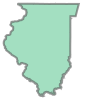

In [323]:
row['outage geometry']

TODO
- Compile the concrete information that we know about this event
- Determine what continuous data we have (imagery over time, space weather data (GIC and SuperMAG)
- Can these 'layers' (need the weather and space weather spatiotemporal maps) yield network data and how might I explore its information over time?
- get additional data - Geo-electric field
- ...